This notebook shows how to
* Obtain information about interface reactions between cathode and electrolyte. (VOPO4 with C3H4O3 (or EC) in this example)
* Plot formation energy as a function of mixing ratio.

Written using:
- pymatgen==2018.3.14

We use the [Materials Project API](https://github.com/materialsproject/mapidoc) to obtain energies of compounds.

In [1]:
from pymatgen import MPRester, Composition
from pymatgen.analysis.phase_diagram import PhaseDiagram
from pymatgen.entries.computed_entries import ComputedEntry
from pymatgen.apps.borg.hive import VaspToComputedEntryDrone
from pymatgen.entries.compatibility import MaterialsProjectCompatibility
from pymatgen.analysis.phase_diagram import ReactionDiagram, PDPlotter, PDEntry
%matplotlib inline

Get all H, P, V, O, C entries by MPRester 

In [2]:
mp = MPRester()
compat = MaterialsProjectCompatibility()
chemsys = ["H", "P", "V","O", "C"]

all_entries = mp.get_entries_in_chemsys(chemsys)

Remove CO, CO2, H2O, VPO5 entries from all_entries, use experimental data and our own calculations

In [3]:
CO_entries = [e for e in all_entries if e.composition.reduced_formula == "CO"]
CO2_entries = [e for e in all_entries if e.composition.reduced_formula == "CO2"]
H2O_entries = [e for e in all_entries if e.composition.reduced_formula == "H2O"]
VPO5_entries = [e for e in all_entries if e.composition.reduced_formula == "VPO5"]

non_solid = ["CO", "CO2", "H2O", "VPO5"]

entries = list(filter(lambda e: e.composition.reduced_formula not in non_solid, all_entries))

Get POTCAR of C, H, O for EC to construct its ComputedEntry

In [4]:
potcars = set()
for e in all_entries:
    if len(e.composition) == 1 and e.composition.reduced_formula in ["C", "H2", "O2"]:
        potcars.update(e.parameters["potcar_symbols"]) 

EC solid phase:
Enthalpy of formation of solid at standard conditions = -590.9 (kJ/mol)

(http://webbook.nist.gov/cgi/cbook.cgi?ID=C96491&Units=SI&Mask=2#Thermo-Condensed)

EC liquid phase:
Enthalpy of formation of solid at standard conditions = -682.8 (kJ/mol)

(http://webbook.nist.gov/cgi/cbook.cgi?ID=C96491&Units=SI&Mask=2#Thermo-Condensed)
 
Get total energy by experimental formation energy, elemental energies and correction to construct EC ComputedEntry.
Apply corection for gas such as O2 etc. Ref: https://journals.aps.org/prb/pdf/10.1103/PhysRevB.73.195107

In [5]:
factor = 1000.0 / 6.0221409e23 / 1.60217662e-19
ec_form_energy = -682.8 * factor

ec = ComputedEntry(composition="C3H4O3", energy=0, parameters={"potcar_symbols": list(potcars)})
ec.data["oxide_type"] = "oxide"

# MaterialsProjectCompatibility
ec = compat.process_entry(ec)

pd = PhaseDiagram(all_entries)
ec.uncorrected_energy = ec_form_energy + sum([pd.el_refs[el].energy_per_atom * amt \
                                              for el, amt in ec.composition.items()]) - ec.correction

Use my own calculation entries

In [6]:
vopo4 = []
vc = VaspToComputedEntryDrone()
for d in ["VOPO4/"]:
    e = vc.assimilate(d)
    e.data["oxide_type"] = "oxide"
    e = compat.process_entry(e)
    vopo4.append(e)

hxvopo4 = []
for d in ["HVOPO4/", "H2VOPO4/"]:
    e = vc.assimilate(d)
    e.data["oxide_type"] = "oxide"
    e = compat.process_entry(e)
    hxvopo4.append(e) 

CO solid phase:
Enthalpy of formation of solid at standard conditions = -1.15 (eV/f.u.) = -110.5 (kJ/mol)

https://en.wikipedia.org/wiki/Carbon_monoxide_%28data_page%29

CO gas phase:
Enthalpy of formation of gas at standard conditions = -1.15 (eV/f.u.) = -110.53 (kJ/mol)

https://en.wikipedia.org/wiki/Carbon_monoxide_%28data_page%29

In [7]:
potcars = set()
for e in all_entries:
    if len(e.composition) == 1 and e.composition.reduced_formula in ["C", "O2"]:
        potcars.update(e.parameters["potcar_symbols"])

co_form_energy = -110.53 * factor

co = ComputedEntry(composition="CO", energy=0, parameters={"potcar_symbols": list(potcars)})
co.data["oxide_type"] = "oxide"
co = compat.process_entry(co)

pd = PhaseDiagram(all_entries)
co.uncorrected_energy = co_form_energy + sum([pd.el_refs[el].energy_per_atom * amt \
                                              for el, amt in co.composition.items()]) - co.correction

CO2 gas phase:
Enthalpy of formation of gas at standard conditions = -4.43 (eV/f.u.) = −393.52 (kJ/mol)

https://en.wikipedia.org/wiki/Carbon_dioxide_%28data_page%29

In [8]:
potcars = set()
for e in all_entries:
    if len(e.composition) == 1 and e.composition.reduced_formula in ["C", "O2"]:
        potcars.update(e.parameters["potcar_symbols"])

co2_form_energy = -393.52 * factor

co2 = ComputedEntry(composition="CO2", energy=0, parameters={"potcar_symbols": list(potcars)})
co2.data["oxide_type"] = "oxide"
co2 = compat.process_entry(co2)

pd = PhaseDiagram(all_entries)
co2.uncorrected_energy = co2_form_energy + sum([pd.el_refs[el].energy_per_atom * amt 
                                                for el, amt in co2.composition.items()]) - co2.correction

H2O liquid phase:
Enthalpy of formation of liquid at standard conditions = -286.629 (kJ/mol)

http://www1.lsbu.ac.uk/water/water_properties.html

In [9]:
potcars = set()
for e in all_entries:
    if len(e.composition) == 1 and e.composition.reduced_formula in ["H2", "O2"]:
        potcars.update(e.parameters["potcar_symbols"])

h2o_form_energy = -286.629 * factor

h2o = ComputedEntry(composition="H2O", energy=0, parameters={"potcar_symbols": list(potcars)})
h2o.data["oxide_type"] = "oxide"
h2o = compat.process_entry(h2o)

pd = PhaseDiagram(all_entries)
h2o.uncorrected_energy = h2o_form_energy + sum([pd.el_refs[el].energy_per_atom * amt for el, amt in h2o.composition.items()]) - h2o.correction

In [10]:
entry1 = vopo4[0]
entry2 = ec
useful_entries = entries + hxvopo4 + [h2o, co2, co]

In [11]:
from scipy import stats
import numpy as np

%matplotlib inline
import matplotlib as mpl

mpl.rcParams['axes.linewidth']=3
mpl.rcParams['lines.markeredgewidth']=2
mpl.rcParams['lines.linewidth']=3
mpl.rcParams['lines.markersize']=13
mpl.rcParams['xtick.major.width']=3
mpl.rcParams['xtick.major.size']=8
mpl.rcParams['xtick.minor.width']=3
mpl.rcParams['xtick.minor.size']=4
mpl.rcParams['ytick.major.width']=3
mpl.rcParams['ytick.major.size']=8
mpl.rcParams['ytick.minor.width']=3
mpl.rcParams['ytick.minor.size']=4

Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
1 - 0.9200 VPO5 + 0.0800 H4(CO)3 -> 0.0600 V3O7 + 0.3200 VPHO5 + 0.3000 VP2O7 + 0.1200 V(CO3)2
2 - 0.9091 VPO5 + 0.0909 H4(CO)3 -> 0.3636 VPHO5 + 0.1364 VO2 + 0.2727 VP2O7 + 0.1364 V(CO3)2
3 - 0.8947 VPO5 + 0.1053 H4(CO)3 -> 0.4211 VPHO5 + 0.1579 VP2O7 + 0.1579 V(CO3)2 + 0.1579 VPO4
4 - 0.8462 VPO5 + 0.1538 H4(CO)3 -> 0.0769 VP2O7 + 0.0769 V(CO3)2 + 0.3077 H2CO3 + 0.6923 VPO4
5 - 0.8421 VPO5 + 0.1579 H4(CO)3 -> 0.0263 V2P5O16 + 0.0789 V(CO3)2 + 0.3158 H2CO3 + 0.7105 VPO4
6 - 0.8400 VPO5 + 0.1600 H4(CO)3 -> 0.0400 V(PO3)3 + 0.0800 V(CO3)2 + 0.3200 H2CO3 + 0.7200 VPO4
7 - 0.7500 VPO5 + 0.2500 H4(CO)3 -> 0.5000 H2CO3 + 0.7500 VPO4 + 0.2500 C
8

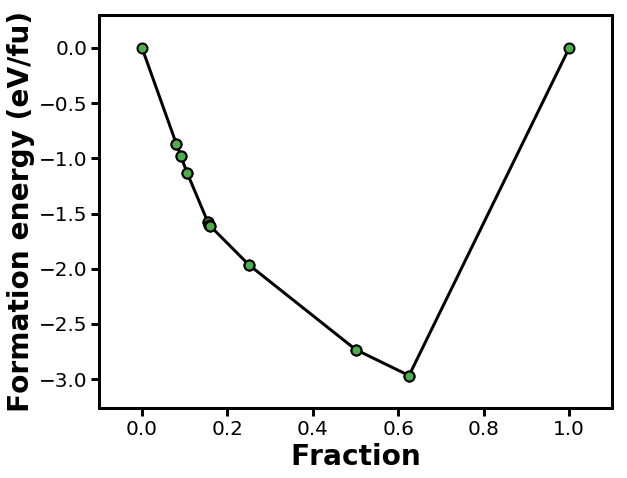

In [12]:
ra = ReactionDiagram(entry1=entry1, entry2=entry2, all_entries=useful_entries)
cpd = ra.get_compound_pd()
plotter = PDPlotter(cpd, show_unstable=False)
plotter.get_plot(label_stable=False, label_unstable=False)
for i, l in ra.labels.items():
    print ("%s - %s" % (i, l))